In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [98]:
with open("/Users/anuraagsrivatsa/Documents/Capstone/EAV/EAV/processed_data_psd/subject2_processed_psd.pkl", "rb") as f:
    subject_eeg = pickle.load(f)

X = subject_eeg["features"]   # expected shape (n_samples, 30, 5, 1)
y_onehot = subject_eeg["labels"]  # expected shape (n_samples, 5) one-hot
if X.ndim == 3:       # (N, 30, 5)
    X = X[..., np.newaxis]
print("X shape:", X.shape)
print("y (one-hot) shape:", y_onehot.shape)

X shape: (400, 30, 5, 1)
y (one-hot) shape: (400, 5)


In [99]:
mapping = np.array([
    [ 0.00,  0.00],   # 0 Neutral
    [-0.40, -0.20],   # 1 Sadness
    [-0.51,  0.59],   # 2 Anger
    [ 0.30,  0.10],   # 3 Happy
    [ 0.20, -0.30],   # 4 Calm
], dtype=np.float32)

y_va = y_onehot.dot(mapping)  # shape (n_samples, 2)

# Keep original class labels (integers) handy for confusion matrix
y_classes = np.argmax(y_onehot, axis=1)

In [100]:
train_ratio = 0.7
num_classes = y_onehot.shape[1]

X_train_list, yva_train_list, yclass_train_list = [], [], []
X_test_list,  yva_test_list,  yclass_test_list  = [], [], []

np.random.seed(42)  # for reproducibility of splits; you can remove if you don't want deterministic splits

for class_idx in range(num_classes):
    class_indices = np.where(y_classes == class_idx)[0]
    class_perm = np.random.permutation(class_indices)
    n_train = int(len(class_perm) * train_ratio)
    train_idx = class_perm[:n_train]
    test_idx  = class_perm[n_train:]

    X_train_list.append(X[train_idx])
    yva_train_list.append(y_va[train_idx])
    yclass_train_list.append(y_classes[train_idx])

    X_test_list.append(X[test_idx])
    yva_test_list.append(y_va[test_idx])
    yclass_test_list.append(y_classes[test_idx])

# concatenate
X_train = np.concatenate(X_train_list, axis=0)
yva_train = np.concatenate(yva_train_list, axis=0)
yclass_train = np.concatenate(yclass_train_list, axis=0)

X_test = np.concatenate(X_test_list, axis=0)
yva_test = np.concatenate(yva_test_list, axis=0)
yclass_test = np.concatenate(yclass_test_list, axis=0)

# shuffle each combined set
train_perm = np.random.permutation(len(X_train))
test_perm  = np.random.permutation(len(X_test))

X_train, yva_train, yclass_train = X_train[train_perm], yva_train[train_perm], yclass_train[train_perm]
X_test,  yva_test,  yclass_test  = X_test[test_perm],  yva_test[test_perm],  yclass_test[test_perm]

print("Train shapes:", X_train.shape, yva_train.shape, yclass_train.shape)
print("Test  shapes:", X_test.shape,  yva_test.shape,  yclass_test.shape)

Train shapes: (280, 30, 5, 1) (280, 2) (280,)
Test  shapes: (120, 30, 5, 1) (120, 2) (120,)


In [101]:
def EEGNet_VA(num_outputs=2, F1=16, D=2, F2=32, dropout_rate=0.5, l2_penalty=0.001, input_shape=(30,5,1)):
    inputs = layers.Input(shape=input_shape)
    reg = regularizers.l2(l2_penalty)

    # Temporal conv
    x = layers.Conv2D(F1, (1,5), padding='same', use_bias=False, kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)

    # Depthwise spatial conv
    x = layers.DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=D, padding='valid',
                               depthwise_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.AveragePooling2D((1,2))(x)
    x = layers.Dropout(dropout_rate)(x)

    # Separable conv
    x = layers.SeparableConv2D(F2, (1,3), padding='same', use_bias=False,
                               depthwise_regularizer=reg, pointwise_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='elu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.5)(x)

    # Output: 2 continuous values (valence, arousal)
    outputs = layers.Dense(num_outputs, activation='linear', name='va_output', kernel_regularizer=reg)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [102]:
model = EEGNet_VA(input_shape=(30,5,1), dropout_rate=0.6, l2_penalty=0.01)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])  # using MAE for regression
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 30, 5, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 5, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 5, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_8              │ (None, 1, 5, 32)       │           960 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 1, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 1, 2, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_8              │ (None, 1, 2, 32)       │         1,120 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 1, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 1, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ va_output (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,770 (26.45 KB)

 Trainable params: 6,610 (25.82 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.9146 - mae: 0.8309 - val_loss: 1.3649 - val_mae: 0.2956
Epoch 2/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7739 - mae: 0.7162 - val_loss: 1.3217 - val_mae: 0.2795
Epoch 3/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7320 - mae: 0.7018 - val_loss: 1.2775 - val_mae: 0.2629
Epoch 4/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6155 - mae: 0.6127 - val_loss: 1.2524 - val_mae: 0.2650
Epoch 5/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5447 - mae: 0.5689 - val_loss: 1.2258 - val_mae: 0.2649
Epoch 6/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5238 - mae: 0.5740 - val_loss: 1.1961 - val_mae: 0.2609
Epoch 7/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4637 - mae: 0.5394 - val_loss: 1.1662 - val_mae: 0.2562
Epoch 8/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4072 - mae: 0.5078 - val_loss: 1.1394 - val_mae: 0.2539
Epoch 9/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3311 - mae: 0.4560 -

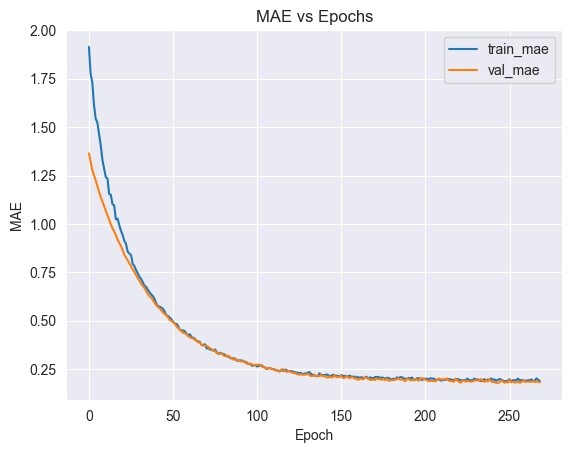

In [103]:
early_stopper = EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, yva_train,
    epochs=400,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, yva_test),
    callbacks=[early_stopper]
)

# Plot training curves (MAE)
plt.figure()
plt.plot(history.history['loss'], label='train_mae')
plt.plot(history.history['val_loss'], label='val_mae')
plt.title('MAE vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion matrix:
 [[17  0  0  0  7]
 [ 8  9  3  0  4]
 [ 7  1 16  0  0]
 [11  0  1 11  1]
 [ 6  0  0  1 17]]

Classification Report (derived from nearest prototype):

              precision    recall  f1-score   support

     Neutral       0.35      0.71      0.47        24
     Sadness       0.90      0.38      0.53        24
       Anger       0.80      0.67      0.73        24
       Happy       0.92      0.46      0.61        24
        Calm       0.59      0.71      0.64        24

    accuracy                           0.58       120
   macro avg       0.71      0.58      0.60       120
weighted avg       0.71      0.58      0.60       120



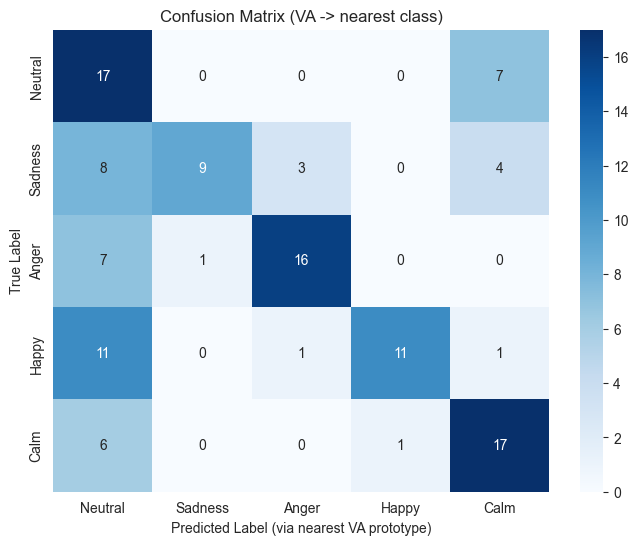

In [104]:
yva_pred = model.predict(X_test)   # shape (n_test, 2)
# nearest prototype/class mapping
# mapping is shape (5,2)
def va_to_class(pred_va, prototypes=mapping):
    # pred_va: (n,2) or (2,)
    pred = np.atleast_2d(pred_va)
    # compute euclidean distances to each prototype
    dists = np.linalg.norm(pred[:, None, :] - prototypes[None, :, :], axis=2)  # (n, 5)
    pred_classes = np.argmin(dists, axis=1)
    return pred_classes

y_pred_classes = va_to_class(yva_pred)
y_true_classes = yclass_test  # from earlier

# confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion matrix:\n", cm)

target_names = ['Neutral', 'Sadness', 'Anger', 'Happy', 'Calm']
print("\nClassification Report (derived from nearest prototype):\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names, zero_division=0))

# plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label (via nearest VA prototype)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (VA -> nearest class)')
plt.show()

In [105]:
def plot_point(model, sample, true_label=None,
               prototypes=mapping, prototype_names=target_names):
    """
    sample: (30,5,1) EEG sample
    true_label: integer class 0–4 (optional)
    model: trained VA regression model
    """

    # Ensure batch dimension
    s = np.array(sample)
    if s.ndim == 3:   # (30,5,1)
        s = s[None, ...]

    # Predict valence/arousal
    va_pred = model.predict(s)
    va_point = va_pred[0]

    # Convert VA → predicted class
    pred_class = va_to_class(va_point)[0]

    # Print actual + predicted labels
    if true_label is not None:
        print(f"True Label:      {true_label} ({prototype_names[true_label]})")
    print(f"Predicted Label: {pred_class} ({prototype_names[pred_class]})")
    print(f"Predicted VA:    ({va_point[0]:.3f}, {va_point[1]:.3f})")

    # --- Plot ---
    plt.figure(figsize=(6,6))

    # Plot class prototypes
    for i, p in enumerate(prototypes):
        plt.scatter(p[0], p[1], s=140, marker='o', edgecolor='k')
        plt.text(p[0]+0.02, p[1]+0.02, f"{i}: {prototype_names[i]}", fontsize=10)

    # Plot predicted point
    plt.scatter(va_point[0], va_point[1], s=140, marker='X')
    plt.text(va_point[0]+0.02, va_point[1]-0.02,
             f"({va_point[0]:.2f}, {va_point[1]:.2f})", fontsize=10)

    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title('Predicted Valence/Arousal and Prototypes')
    plt.grid(True)
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
True Label:      2 (Anger)
Predicted Label: 2 (Anger)
Predicted VA:    (-0.307, 0.298)


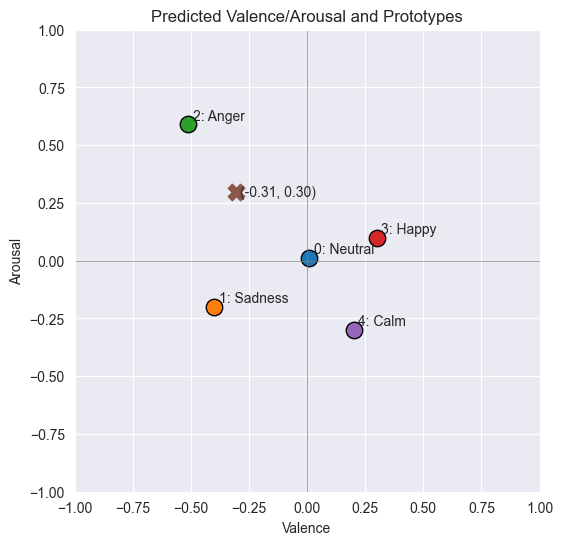

In [96]:
plot_point(model, X_test[100], yclass_test[100])